<div style="display: flex; text-align:center; background-color: rgb(153,102,153);" >
<h1 style="margin: auto; padding: 30px; ">Produisez une étude de marché avec Python <br></h1>

 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">1 - Importation des librairies et fichiers</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition

from scipy.cluster.hierarchy import ward, dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.stats as st

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv("df_final.csv", index_col="zone")

# Affichage des nombres : séparateur des milliers, et réduction du nombre de décimales
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, Afghanistan to Zimbabwe
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   population              231 non-null    float64
 1   dispo_ali(kg/pers/an)   231 non-null    float64
 2   dispo_intérieure        231 non-null    float64
 3   importation (tonnes)    231 non-null    float64
 4   production (tonnes)     231 non-null    float64
 5   PIB/hab (US$)           231 non-null    float64
 6   prix import poulet US$  231 non-null    float64
 7   stab_p                  231 non-null    float64
dtypes: float64(8)
memory usage: 16.2+ KB


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">2 - Analyse </h2>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.1- Préparation et normalisation des données </h3>

<AxesSubplot:>

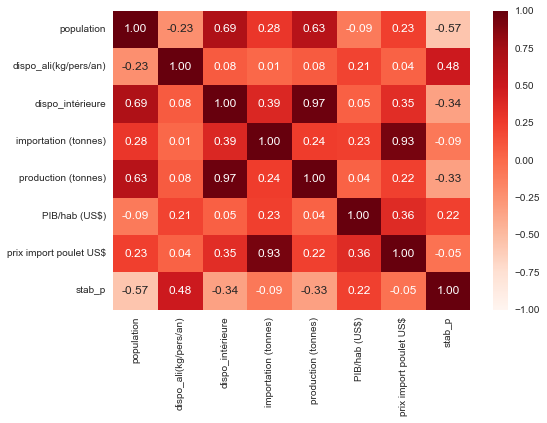

In [4]:
#On va regarder un peu nos données
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="Reds", fmt="0.2f")

On voit que dispo intérieur et production sont correlés 0.97
Egalement prix import et import correlées a 0.93

On sait que des variables trop correlées peuvent diminuer l'interprétabilité et la robustesse de nos modèles
On va devoir enlever notre var production pour garder dispo_intérieur et finalement supprimer prix import

In [5]:
df = df[['population','dispo_ali(kg/pers/an)','dispo_intérieure','importation (tonnes)','PIB/hab (US$)','stab_p']]

In [6]:
#Transformation en array Numpy
X= df.values
print(X.shape)
print(type(X))

(231, 6)
<class 'numpy.ndarray'>


In [7]:
#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# On vérifie que les données sont bien centrées : la moyenne vaut 0 et l'écart type vaut 1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00


In [8]:
# Df avec les données centrées reduites
scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
scaled_df.head()

,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p
zone,,,,,,
Afghanistan,0.48,-1.37,-0.32,-0.21,-0.87,-3.65
Afrique du Sud,1.04,0.63,2.01,3.33,-0.29,-0.24
Albanie,-0.43,-0.50,-0.33,-0.14,-0.34,0.29
Algérie,0.61,-1.09,-0.07,-0.40,-0.39,-1.47
Allemagne,1.73,-0.32,1.58,5.72,1.67,-0.24


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.2 - CAH </h3>

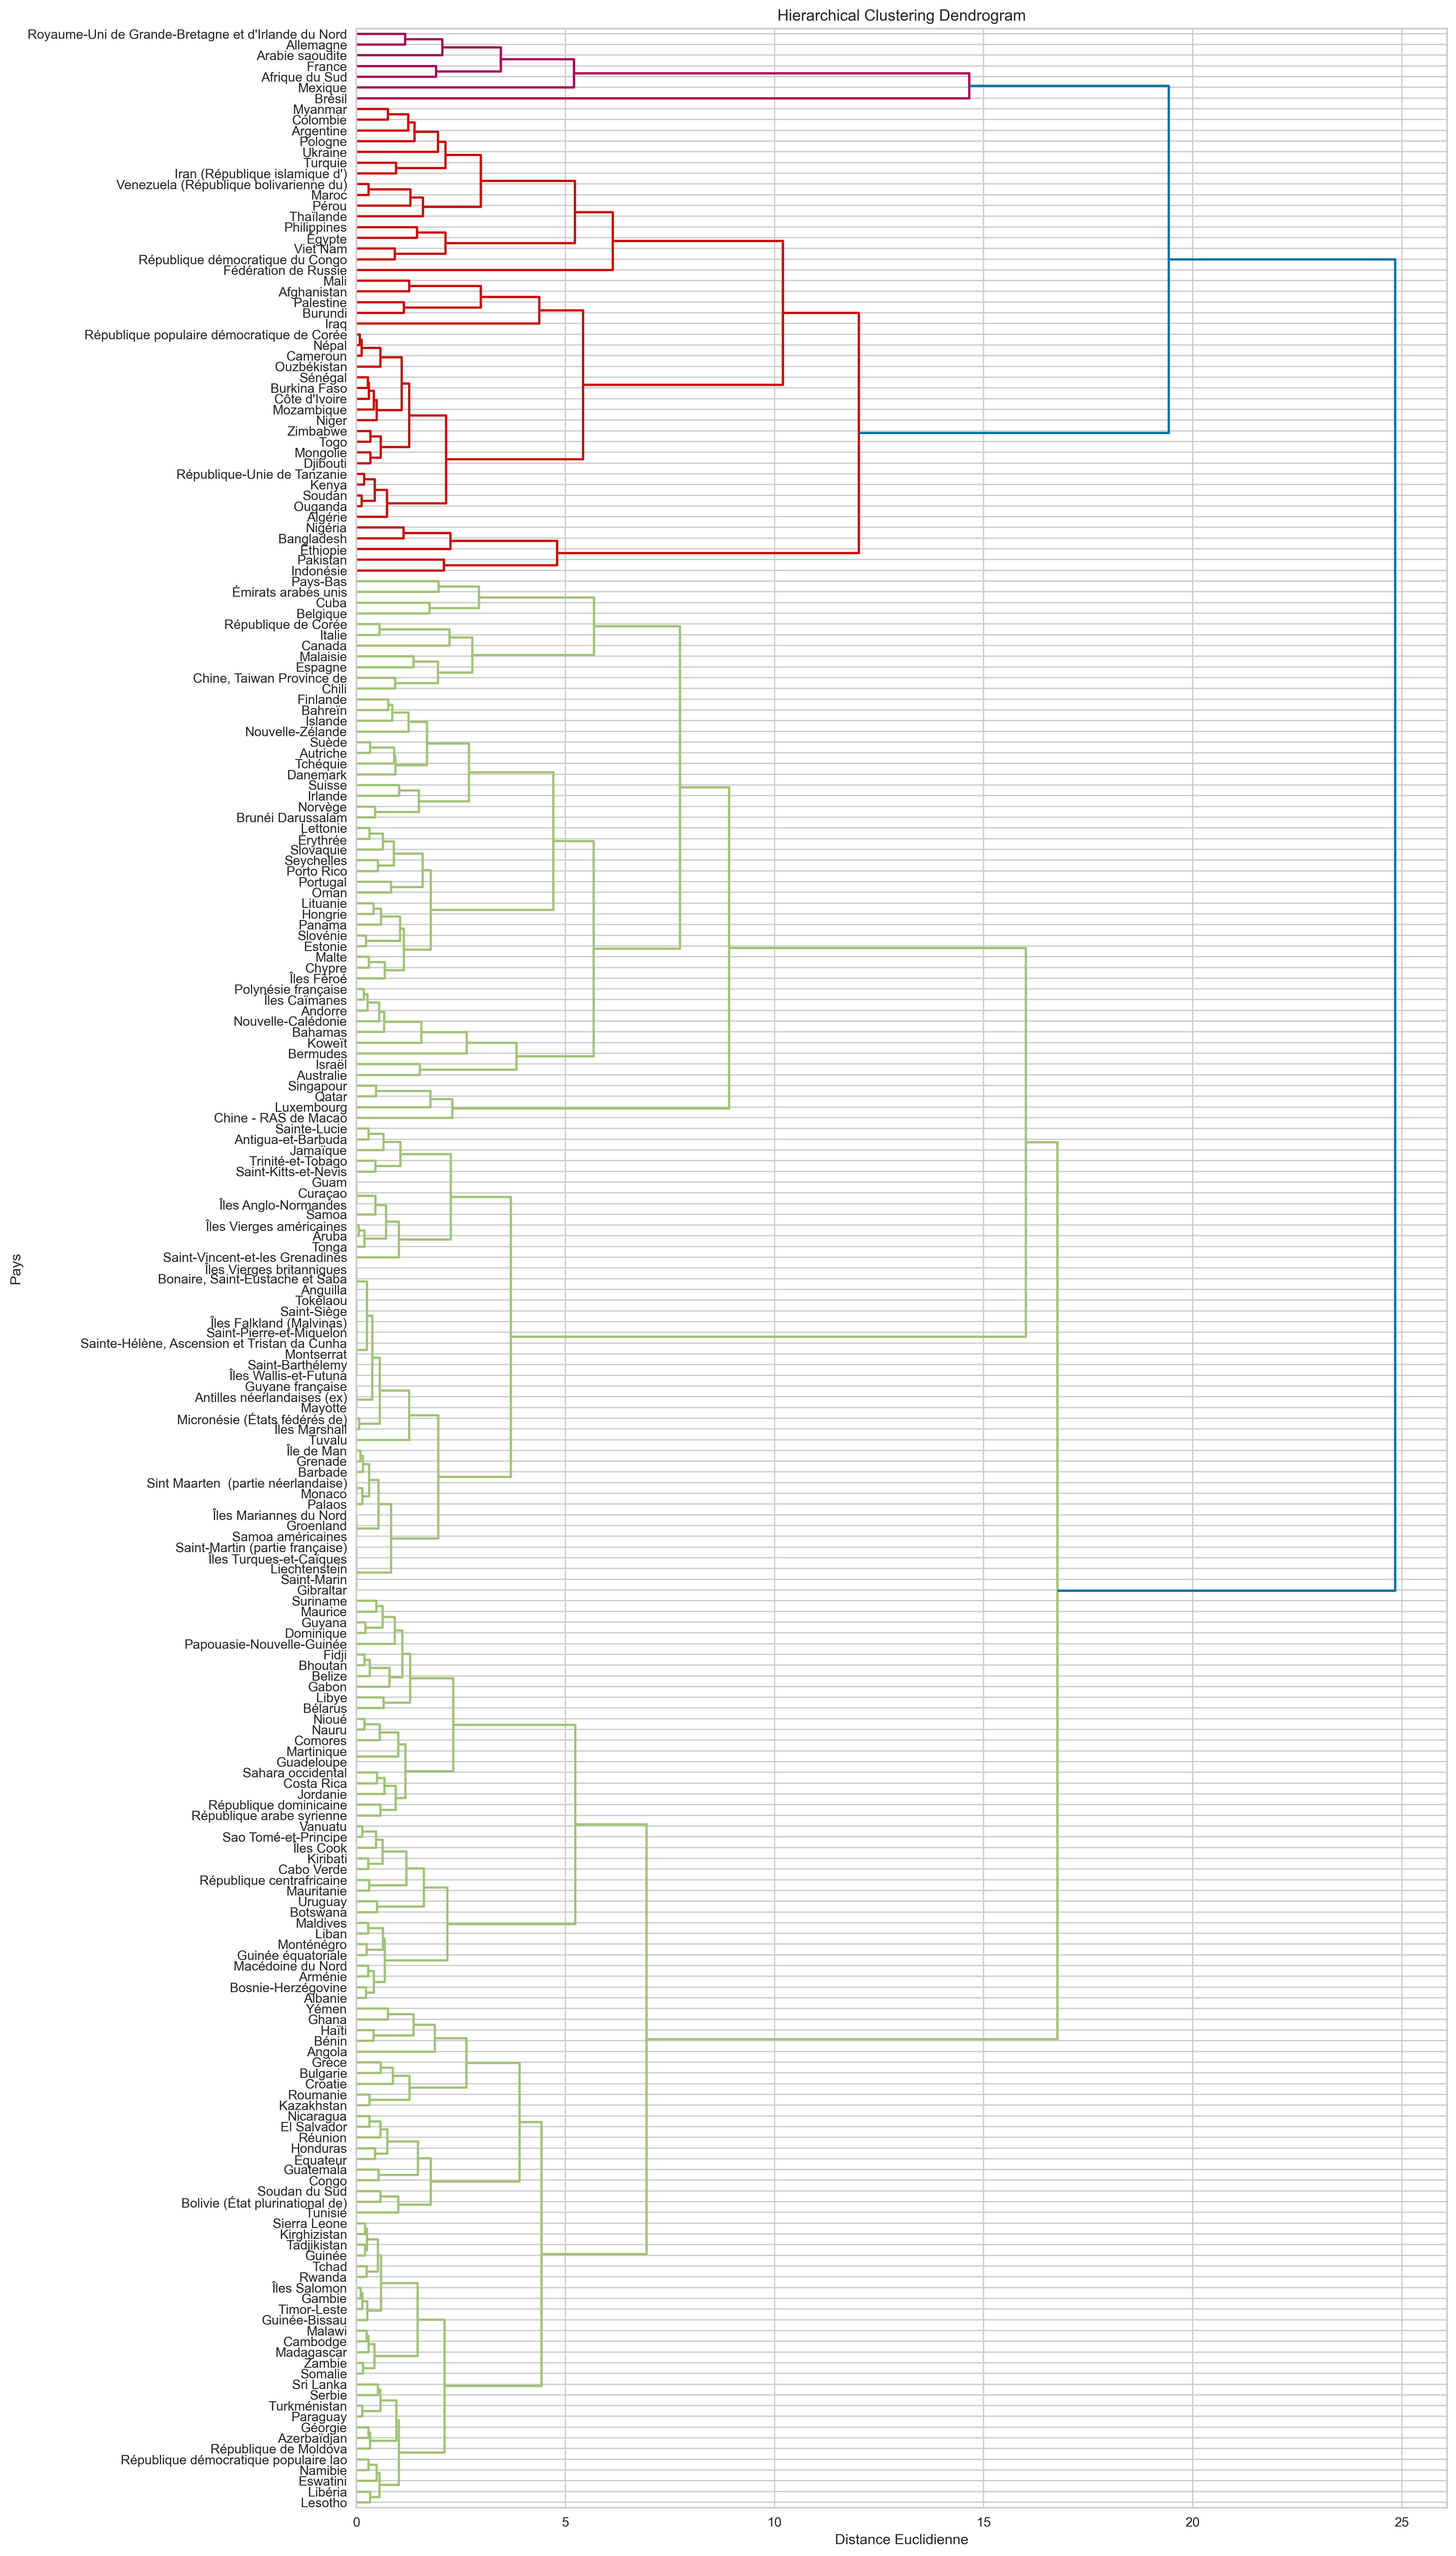

In [9]:
#Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward 
#Affichage du dendogramme global

plt.figure(figsize=(15,35), dpi=300)
Z = linkage(scaled_df, method='ward', metric='euclidean')
dendrogram(
    Z, 
    labels=df.index, 
    color_threshold=18,
    leaf_font_size=10,
    orientation = "right",)
plt.title('Hierarchical Clustering Dendrogram')
plt.savefig('C:/Users\Camil/Desktop/Papiers-camille2021/OPCR/Projet9/Livrables/dendogram.jpg')
plt.xlabel('Distance Euclidienne')
plt.ylabel('Pays')
plt.show()

In [10]:
#On va prendre pour être plus précis (pour éviter d'être trop généraliste) une distance euclidienne d'environ 15 
#ce qui nous fait 5 clusters

NB_CLUSTER=5

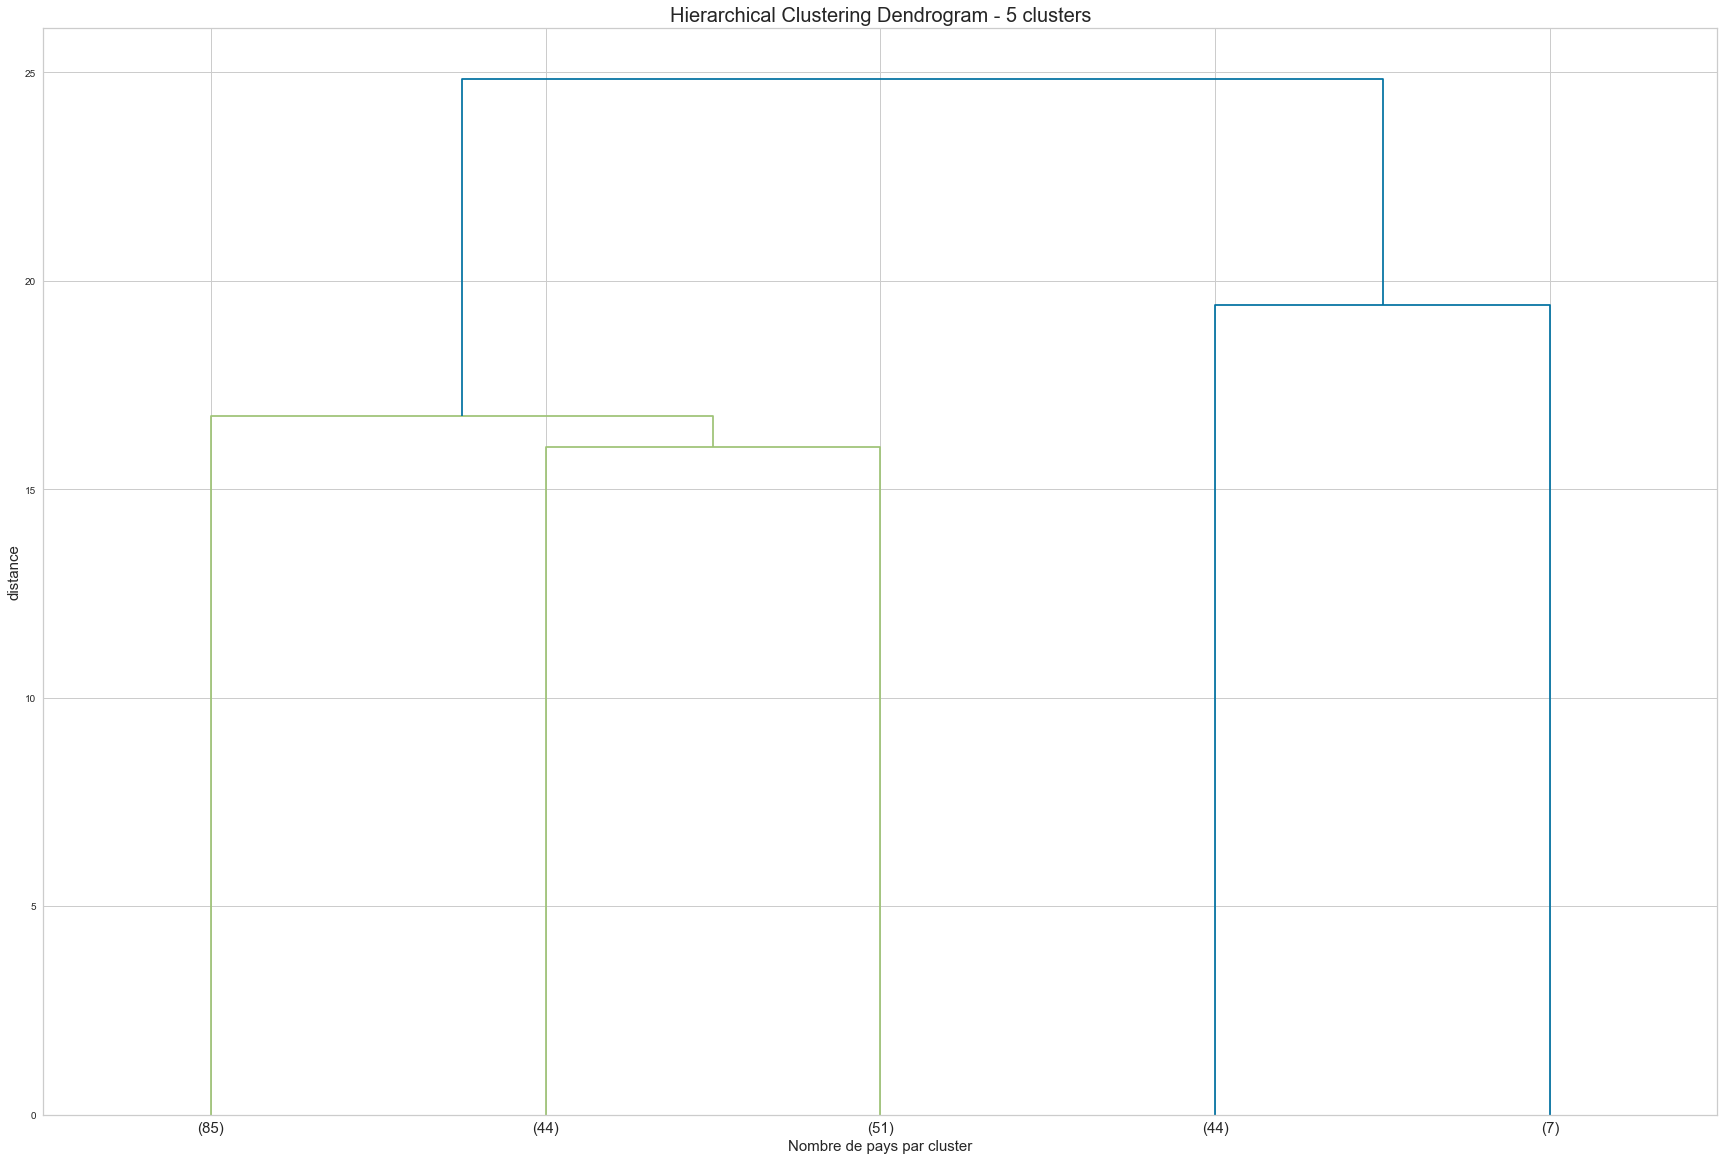

In [11]:
#On coupe le dendogram en 5 groupes pour un meilleur visuel du partitionnement:
fig=plt.figure(figsize=(30,20))
plt.title('Hierarchical Clustering Dendrogram - {} clusters'.format(NB_CLUSTER), fontsize=20)
plt.ylabel('distance', fontsize=15)
plt.xlabel('Nombre de pays par cluster', fontsize=15)



dendrogram(Z, labels=df.index, p=NB_CLUSTER,truncate_mode='lastp', leaf_font_size=15)

plt.savefig('C:/Users\Camil/Desktop/Papiers-camille2021/OPCR/Projet9/Livrables/coupe_dendogram.jpg')
plt.show()

In [12]:
#Identification des 5 clusters
groupe_cah = fcluster(Z, NB_CLUSTER, criterion='maxclust')
print('Numérotation des clusters : ' + str(np.unique(groupe_cah)))

Numérotation des clusters : [1 2 3 4 5]


In [13]:
#Affichage des pays selon leurs clusters
idea_g = np.argsort(groupe_cah) #Trie des index
df_gr = pd.DataFrame(df.index[idea_g],groupe_cah[idea_g]).reset_index()
df_gr = df_gr.rename(columns={'index':'cluster_CAH'})
df_gr.head()

,cluster_CAH,zone
0,1,Nauru
1,1,Sri Lanka
2,1,Grèce
3,1,Martinique
4,1,Ghana


In [14]:
#Intégration des clusters dans notre df de base
df_cah = pd.merge(df, df_gr, on='zone',how='left')
df_cah.to_csv('df_cah.csv')
df_cah.head()

,zone,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p,cluster_CAH
0,Afghanistan,"36,296,113.00",1.53,57.00,"29,000.00","2,058.40",-2.80,4
1,Afrique du Sud,"57,009,756.00",35.69,"2,118.00","514,000.00","13,860.30",-0.15,5
2,Albanie,"2,884,169.00",16.36,47.00,"38,000.00","12,771.00",0.26,1
3,Algérie,"41,389,189.00",6.38,277.00,"2,000.00","11,737.40",-1.10,4
4,Allemagne,"82,658,409.00",19.47,"1,739.00","842,000.00","53,071.50",-0.15,5


In [15]:
#Intégration des clusters dans le df normé
df_groupes_cah = pd.merge(scaled_df, df_gr, on='zone',how='left')
df_groupes_cah.head()

,zone,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p,cluster_CAH
0,Afghanistan,0.48,-1.37,-0.32,-0.21,-0.87,-3.65,4
1,Afrique du Sud,1.04,0.63,2.01,3.33,-0.29,-0.24,5
2,Albanie,-0.43,-0.50,-0.33,-0.14,-0.34,0.29,1
3,Algérie,0.61,-1.09,-0.07,-0.40,-0.39,-1.47,4
4,Allemagne,1.73,-0.32,1.58,5.72,1.67,-0.24,5


In [16]:
#Taille des clusters
print('Il y a ' + str(len(df_groupes_cah[df_groupes_cah['cluster_CAH'] == 1]['zone'])) + " pays dans le cluster 1")
print('Il y a ' + str(len(df_groupes_cah[df_groupes_cah['cluster_CAH'] == 2]['zone'])) + " pays dans le cluster 2")
print('Il y a ' + str(len(df_groupes_cah[df_groupes_cah['cluster_CAH'] == 3]['zone'])) + " pays dans le cluster 3")
print('Il y a ' + str(len(df_groupes_cah[df_groupes_cah['cluster_CAH'] == 4]['zone'])) + " pays dans le cluster 4")
print('Il y a ' + str(len(df_groupes_cah[df_groupes_cah['cluster_CAH'] == 5]['zone'])) + " pays dans le cluster 5")

Il y a 85 pays dans le cluster 1
Il y a 44 pays dans le cluster 2
Il y a 51 pays dans le cluster 3
Il y a 44 pays dans le cluster 4
Il y a 7 pays dans le cluster 5


In [17]:
#Comparaison des moyennes afin d'identifier les clusters les plus porteur 
moyenne = df_groupes_cah.groupby('cluster_CAH').mean()
moyenne

,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p
cluster_CAH,,,,,,
1,-0.31,-0.49,-0.27,-0.21,-0.44,0.04
2,-0.50,1.41,-0.37,-0.37,-0.33,1.05
3,-0.25,0.21,-0.06,0.17,1.42,0.37
4,1.09,-0.78,0.43,-0.08,-0.58,-1.48
5,1.96,0.49,3.37,4.10,0.73,-0.47


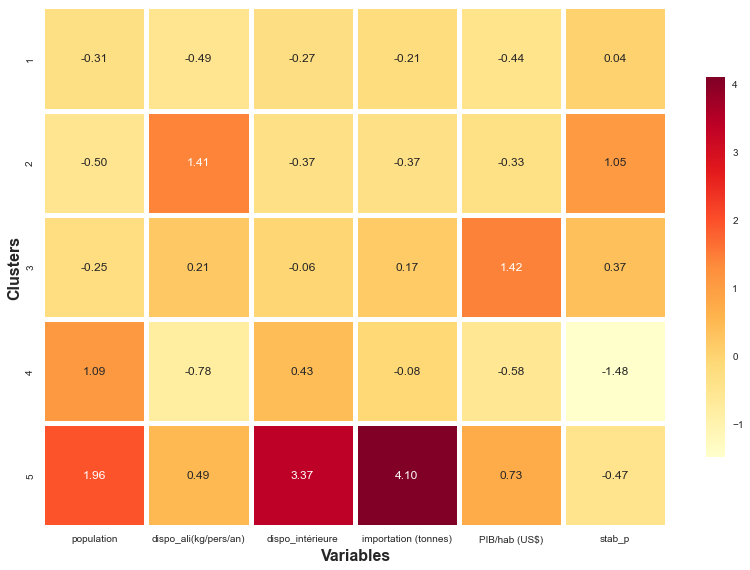

In [18]:
#Visuel 
moyennes = df_groupes_cah.groupby('cluster_CAH').mean()

# Visuel 
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(moyennes, linewidth=5, annot = True, fmt='.2f', cmap="YlOrRd", cbar_kws={"shrink": 0.5}, square=True)
plt.ylabel("Clusters",weight='bold',size=16)
plt.xlabel("Variables",weight='bold',size=16)
plt.show()

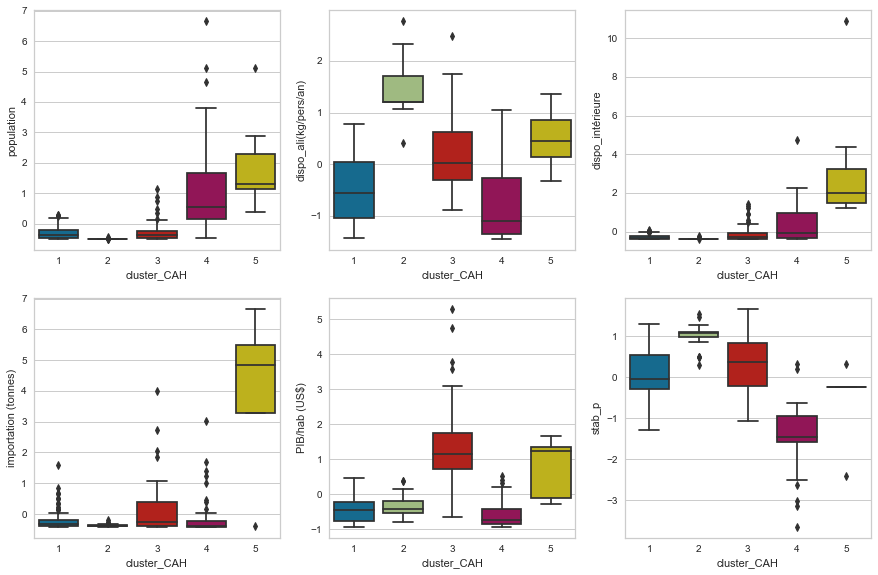

In [19]:
#Caractéristiques visuelle des groupes par Boxplot

plt.figure(figsize=(15,15))
plt.subplot(331)
sns.boxplot(data=df_groupes_cah, x='cluster_CAH', y='population')

plt.subplot(332)
sns.boxplot(data=df_groupes_cah, x='cluster_CAH', y='dispo_ali(kg/pers/an)')

plt.subplot(333)
sns.boxplot(data=df_groupes_cah, x='cluster_CAH', y='dispo_intérieure')

plt.subplot(334)
sns.boxplot(data=df_groupes_cah, x='cluster_CAH', y='importation (tonnes)')

plt.subplot(335)
sns.boxplot(data=df_groupes_cah, x='cluster_CAH', y='PIB/hab (US$)')

plt.subplot(336)
sns.boxplot(data=df_groupes_cah, x='cluster_CAH', y='stab_p')

plt.savefig("C:/Users\Camil/Desktop/Papiers-camille2021/OPCR/Projet9/Livrables/boxplot_comparaison_CAH.jpg")

plt.show()

ANALYSE CLUSTERS METHODE CAH : 

- **Cluster 5**  Forte pop, consomme bcp de poulet, importe bcp, plutôt bonne activité éco donc pays riches, pays plutôt stables : ON VALIDE 
- **Cluster 4** Forte pop, moyenne dispo de poulet, importe peu, faible activité économique, pays très instables : A EVITER
- **Cluster 3** Faible pop, faible dispo int, importations moyennes, très bonnes activités économiques, pays très stables : ON VALIDE 
- **Cluster 2** Très faible pop, très faible conso de poulet, import très faible, faible activité économique, pays très stables : A EVITER
- **Cluster 1** Faible pop, faible conso de poulet, importe peu, faible activité économique, pays moyennement stables: A EVITER

Les meilleurs clusters sont les clusters 5 et 3 


On part du principe que l'activité économique et la stabilité sont des facteurs déterminants pour le choix des clusters à retenir, combiné à l'importation, le nb de population et la dispo en poulet

## Résultat CAH

### On va garder les clusters : 5 et 3 

In [20]:
paysCAH1 = df_groupes_cah.loc[df_groupes_cah['cluster_CAH'] == 5]
#On précise qu'on veut garder les pays du cluster 3 stables (>0)
paysCAH2 = df_groupes_cah.loc[(df_groupes_cah['cluster_CAH'] == 3) 
                              & (df_groupes_cah['stab_p']>0)] 
pays = [paysCAH1,paysCAH2]
pays_CAH = pd.concat(pays)
pays_CAH["zone"].unique()

array(['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Brésil',
       'France', 'Mexique',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Andorre',
       'Bahamas', 'Bermudes', 'Brunéi Darussalam', 'Canada', 'Chypre',
       'Cuba', 'Érythrée', 'Estonie', 'Finlande', 'Hongrie',
       'Îles Caïmanes', 'Îles Féroé', 'Irlande', 'Italie', 'Koweït',
       'Lettonie', 'Lituanie', 'Luxembourg', 'Malte', 'Norvège',
       'Nouvelle-Calédonie', 'Oman', 'Panama', 'Polynésie française',
       'Porto Rico', 'Portugal', 'Qatar', 'République de Corée',
       'Seychelles', 'Singapour', 'Slovaquie', 'Slovénie'], dtype=object)

In [21]:
#Soit 40 pays
len(pays_CAH)

40

In [22]:
# On sauvegarde ce fichier.
pays_CAH.to_csv('CAH_result.csv',index=False)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.3 - K-Means </h3>

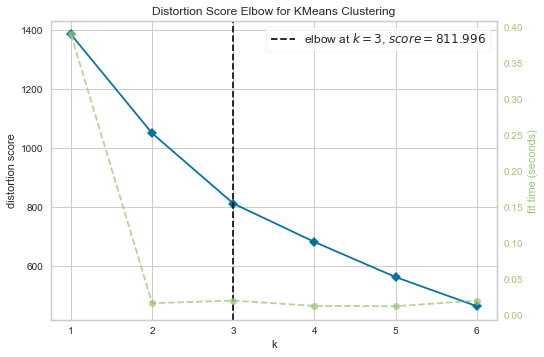

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Nombre de choix de cluster avec méthode du coude:3
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,7))
visualizer.fit(X_scaled)
visualizer.show()

Cela nous montre qu'au niveau du coude, le clustering ne s'améliore plus lorsque k augmente soit 3 clustering pour un partitionnement optimal. 

On va quand même regarder avec le coefficient de silhouette. 

Text(0.5, 0, 'Number of clusters')

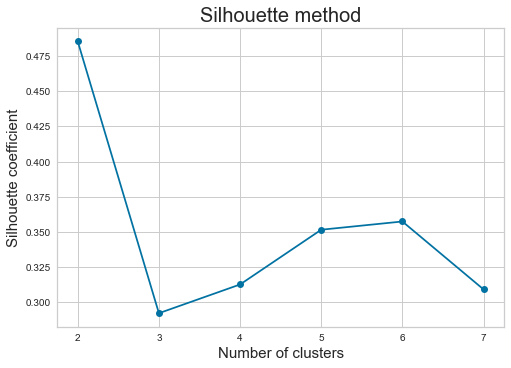

In [24]:
from sklearn.metrics import silhouette_score

# Coefficient de Silhouette
silhouettes = []
for num_cluster in range(2, 8): #On regarde de 2 à 8 clusters)
    cls = cluster.KMeans(n_clusters=num_cluster, n_init=7, init='k-means++',random_state=110)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2,8), silhouettes, marker='o')  
plt.title('Silhouette method', fontsize=20)
plt.ylabel('Silhouette coefficient', fontsize=15)
plt.xlabel("Number of clusters", fontsize=15)

D'après le coeff de silhouette, le choix du nombre de cluster optimal serait de 2 avec un coef de 0.48.
On se basera plutôt sur 3 clusters car avec 2 cluster seulement, il y aurait énormément de pays donc plus difficilement analysable

In [25]:
#Création des clusters
cls3 = cluster.KMeans(n_clusters=3) #On crée notre modele 
cls3.fit(X_scaled) # On l'entraine

KMeans(n_clusters=3)

In [26]:
#Analyse des clusters du K-Means
print(f'Somme des distances entre les points d\'un cluster et son centroïde : {round(cls3.inertia_,1)}\nNombre d\'itérations requises pour couvrir la plage : {cls3.n_iter_}')

Somme des distances entre les points d'un cluster et son centroïde : 812.0
Nombre d'itérations requises pour couvrir la plage : 9


In [27]:
cls3.predict(X_scaled)

array([0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0,
       2, 0, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2,
       1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 2,
       2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2,
       0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0,
       0, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2,
       0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
       0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0,
       0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0])

In [28]:
#Index trié des clusters
idk = np.argsort(cls3.labels_)

#Affichage des observations selon leurs clusters
df_kmeans3 = pd.DataFrame(df.index[idk], cls3.labels_[idk]).reset_index()
df_kmeans3 = df_kmeans3.rename(columns={'index':'cluster_km'})
df_kmeans3.head()

,cluster_km,zone
0,0,Afghanistan
1,0,Niger
2,0,Nicaragua
3,0,Népal
4,0,Namibie


In [29]:
# Ajout des clusters à notre df de base pour l'enregistrer
df_kmeans_cls = pd.merge(df, df_kmeans3, how='inner', on='zone')
df_kmeans_cls.to_csv('df_kmeans.csv')
df_kmeans_cls.head()

,zone,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p,cluster_km
0,Afghanistan,"36,296,113.00",1.53,57.00,"29,000.00","2,058.40",-2.80,0
1,Afrique du Sud,"57,009,756.00",35.69,"2,118.00","514,000.00","13,860.30",-0.15,1
2,Albanie,"2,884,169.00",16.36,47.00,"38,000.00","12,771.00",0.26,0
3,Algérie,"41,389,189.00",6.38,277.00,"2,000.00","11,737.40",-1.10,0
4,Allemagne,"82,658,409.00",19.47,"1,739.00","842,000.00","53,071.50",-0.15,1


In [30]:
# Ajout des clusters a notre df normé
df_kmeans = pd.merge(scaled_df, df_kmeans3, how='inner', on='zone')
df_kmeans.head()

,zone,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p,cluster_km
0,Afghanistan,0.48,-1.37,-0.32,-0.21,-0.87,-3.65,0
1,Afrique du Sud,1.04,0.63,2.01,3.33,-0.29,-0.24,1
2,Albanie,-0.43,-0.50,-0.33,-0.14,-0.34,0.29,0
3,Algérie,0.61,-1.09,-0.07,-0.40,-0.39,-1.47,0
4,Allemagne,1.73,-0.32,1.58,5.72,1.67,-0.24,1


In [31]:
#Taille des clusters
print('Il y a ', str(len(df_kmeans[df_kmeans['cluster_km'] == 0]['zone'])) + " pays dans le cluster 1")
print('Il y a ',str(len(df_kmeans[df_kmeans['cluster_km'] == 1]['zone'])) + " pays dans le cluster 2")
print('Il y a ',str(len(df_kmeans[df_kmeans['cluster_km'] == 2]['zone'])) + " pays dans le cluster 3")

Il y a  91 pays dans le cluster 1
Il y a  23 pays dans le cluster 2
Il y a  117 pays dans le cluster 3


In [32]:
#Tableau de comparaison des clusters par les centroïdes pour les différencier
centroids = cls3.cluster_centers_
df_centroides = pd.DataFrame(centroids, columns=df.columns)
df_centroides

,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p
0,-0.06,-0.81,-0.17,-0.21,-0.58,-0.56
1,2.25,-0.13,1.92,1.73,0.12,-1.07
2,-0.40,0.66,-0.24,-0.18,0.42,0.65


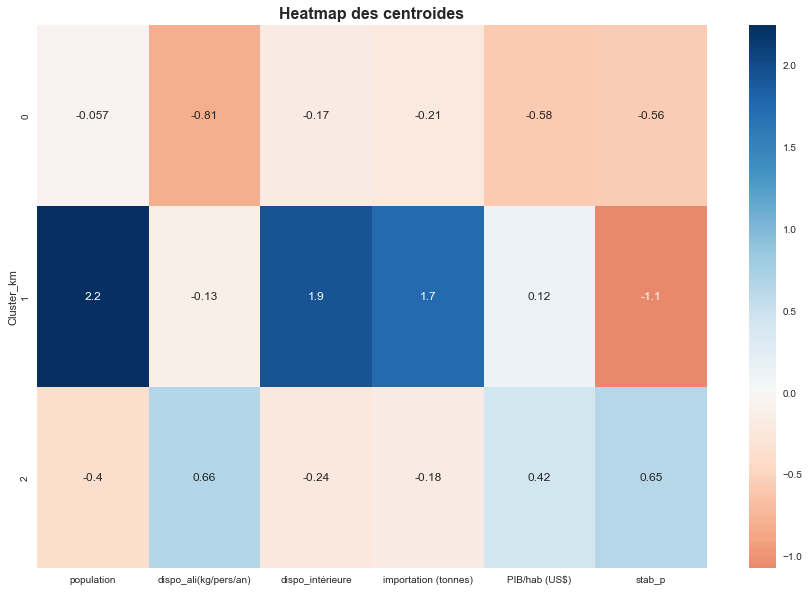

In [33]:
#Visuel de comparaison des centroïdes
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_centroides, center=0, cmap='RdBu', annot=True)
plt.ylabel('Cluster_km')
plt.title('Heatmap des centroides', fontsize=16, fontweight='bold');

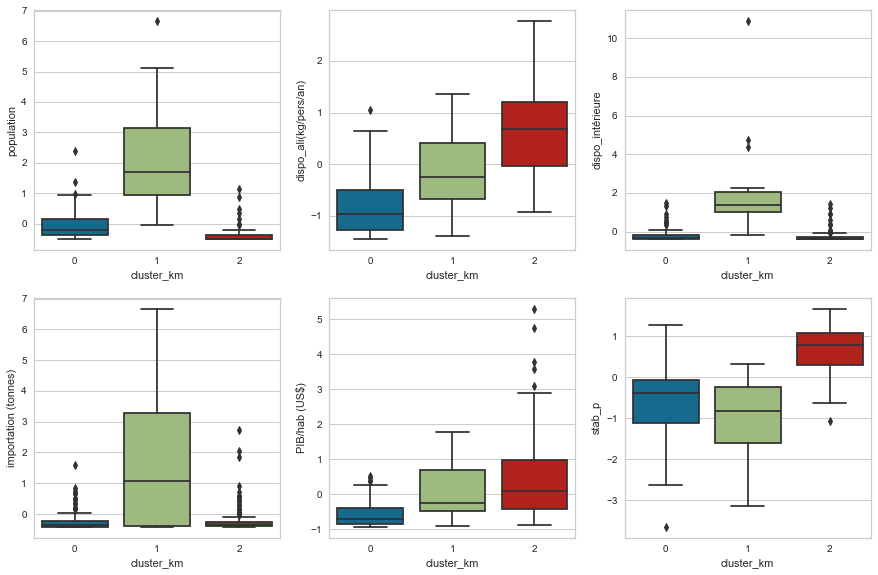

In [34]:
#Visuel boxplot 
boxkmeans = df_kmeans.set_index('zone')

plt.figure(figsize=(15,15))
plt.subplot(331)
sns.boxplot(data=boxkmeans, x='cluster_km', y='population')

plt.subplot(332)
sns.boxplot(data=boxkmeans, x='cluster_km', y='dispo_ali(kg/pers/an)')

plt.subplot(333)
sns.boxplot(data=boxkmeans, x='cluster_km', y='dispo_intérieure')

plt.subplot(334)
sns.boxplot(data=boxkmeans, x='cluster_km', y='importation (tonnes)')

plt.subplot(335)
sns.boxplot(data=boxkmeans, x='cluster_km', y='PIB/hab (US$)')

plt.subplot(336)
sns.boxplot(data=boxkmeans, x='cluster_km', y='stab_p')

plt.savefig("C:/Users\Camil/Desktop/Papiers-camille2021/OPCR/Projet9/Livrables/boxplot_comparaison_KMeans.jpg")

plt.show()

ANALYSE DES CLUSTERS :


**Cluster 1** : Population faible, faible dispo intérieure, importation peu, faible activité économique, et moitié des pays stables et l'autres moitié instables : ON NE VALIDE PAS 

**Cluster 2** :  Bonne population, bonne dispo intérieure, importe beaucoup, bonne activité économique, pays plutôt instables :  ON PEUT VALIDER SOUS RESERVE

**Cluster 3** : Faible population, faible dispo intérieur, importe peu, tres bonne activité éco (PIB), et très stables : ON VALIDE


D'un côté, on a le cluster 3 qui importe peu, faible pop relativemEnt riche et très stable et de l'autre le cluster 2 avec seulement 23 pays mais qui importent beaucoup, grande population, très bonne activité économique, mais moyennement stables. On va combiner les deux et faire ensuite une comparaison avec les pays trouvés en CAH pour grandement diminuer le nombre de choix 

In [35]:
# Regarder les pays du cluster 2 et 3 méthode kmeans 
payskm3 = df_kmeans.loc[(df_kmeans['cluster_km'] == 1) & (df_kmeans['stab_p'] >= -0.5)] #On garde seulement les pays qui sont plutôt stables
payskm2 = df_kmeans.loc[df_kmeans['cluster_km'] == 2]
pays2 = [payskm3, payskm2]
pays_KM = pd.concat(pays2)
pays_KM['zone'].unique()

array(['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Espagne',
       'France', 'Mexique', 'Pays-Bas',
       'République démocratique du Congo',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Viet Nam',
       'Andorre', 'Anguilla', 'Antigua-et-Barbuda',
       'Antilles néerlandaises (ex)', 'Aruba', 'Australie', 'Autriche',
       'Bahamas', 'Bahreïn', 'Barbade', 'Belgique', 'Bermudes', 'Bhoutan',
       'Bonaire, Saint-Eustache et Saba', 'Brunéi Darussalam',
       'Cabo Verde', 'Canada', 'Chili', 'Chine - RAS de Macao', 'Chypre',
       'Comores', 'Costa Rica', 'Cuba', 'Curaçao', 'Danemark',
       'Dominique', 'Émirats arabes unis', 'Érythrée', 'Estonie', 'Fidji',
       'Finlande', 'Gabon', 'Gibraltar', 'Grenade', 'Groenland',
       'Guadeloupe', 'Guam', 'Guinée équatoriale', 'Guyana',
       'Guyane française', 'Hongrie', 'Île de Man',
       'Îles Anglo-Normandes', 'Îles Caïmanes',
       'Îles Falkland (Malvinas)', 'Îles Féroé', 'Îles Mariannes du Nord',


In [36]:
pays_KM['zone'].nunique()

127

In [37]:
#On enregistre les résultats
pays_KM.to_csv('result_kmeans.csv')

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.4- ACP </h3>

On va réaliser une ACP sur les données entières

### Choix du nombre de composantes à analyser

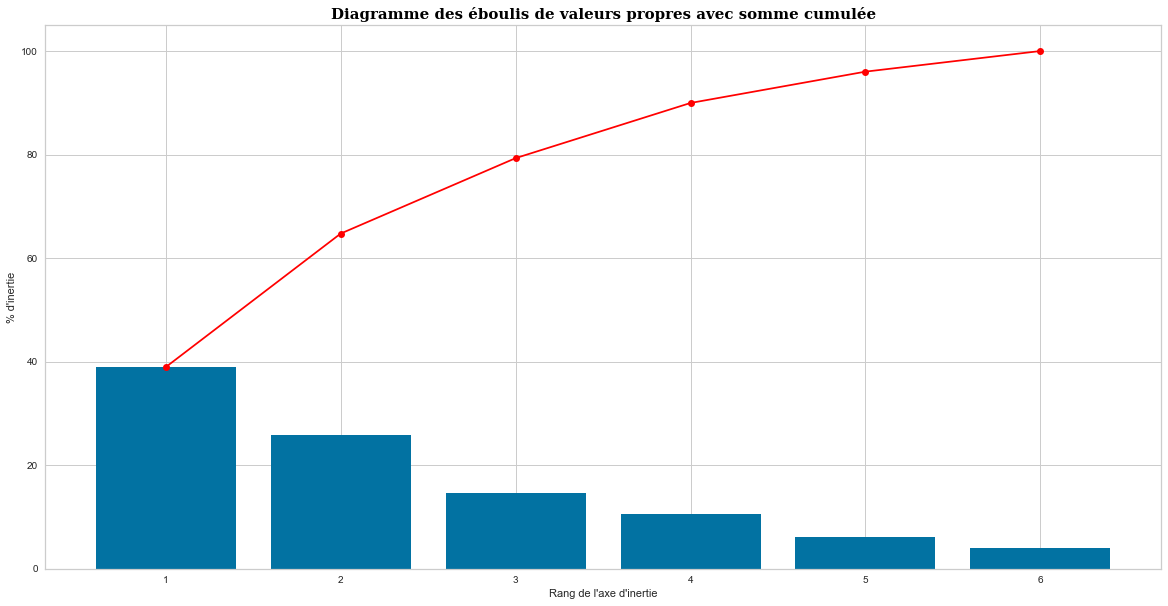

In [38]:
#Représentation de la variance expliquée: Diagramme des éboulis de valeurs propres avec somme cumulée


pca = decomposition.PCA()
X_projected = pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(20,10))
plt.bar(np.arange(len(scree))+1, scree, )
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("% d'inertie")
plt.title("Diagramme des éboulis de valeurs propres avec somme cumulée",
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15});

plt.savefig("C:/Users\Camil/Desktop/Papiers-camille2021/OPCR/Projet9/Livrables/eboulis_valeurs_propres.png")
plt.show()

In [39]:
# Variance captée par chaque nouvelle composante
scree = (pca.explained_variance_ratio_*100).round(2)
print('Variance expliquée pour chaque composante',scree)
print()
# Pourcentage de variance expliquée
scree_cum = scree.cumsum().round(2)
print('% variance expliquée cumulée',scree_cum)

Variance expliquée pour chaque composante [38.95 25.79 14.57 10.66  6.05  3.98]

% variance expliquée cumulée [ 38.95  64.74  79.31  89.97  96.02 100.  ]


En utilisant la méthode du coude, on voit que c'est à partir de la 3ème composante que le pourcentage d'inertie diminue lentement. En s'arrêtant à 3 composantes nous aurons donc environ 80% de la variance et 20% de perte d'information.

On va vérifier avec **la méthode de Kaiser** pour être plus précis :

On prend 100% de notre variance expliquée / par le nombre de variables soit 6 = 16.66
C a d qu'on ne prendra pas la composante qui donnera moins de 16.66%

**Soit jusqu'à F2 25.79%**

### Cercle des corrélations


But : simplifier l'ensemble des 6 variables en 2 variables principales afin d'identifier des similitude, on parlera alors de corrélation des variables.

In [40]:
features = scaled_df.columns

#On choisit 2 composantes principales.
n_comp = 2

pca = decomposition.PCA(n_components=n_comp)# On crée notre modèle
pca.fit(X_scaled) #On l'entraîne

PCA(n_components=2)

In [41]:
#Coeff des composantes principales F1 et F2 en fonction des variables 
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
x_list = range(1, n_comp+1)
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p
F1,0.58,-0.27,0.49,0.28,-0.10,-0.51
F2,0.06,0.51,0.35,0.48,0.54,0.31


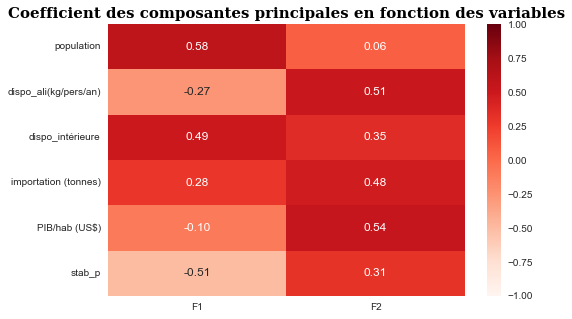

In [42]:
#Visuel avec les coef des composantes principales F1-F2 en fonction des variables
upp_mat = np.triu(df.corr())

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="Reds", fmt="0.2f")
plt.title("Coefficient des composantes principales en fonction des variables",
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15});

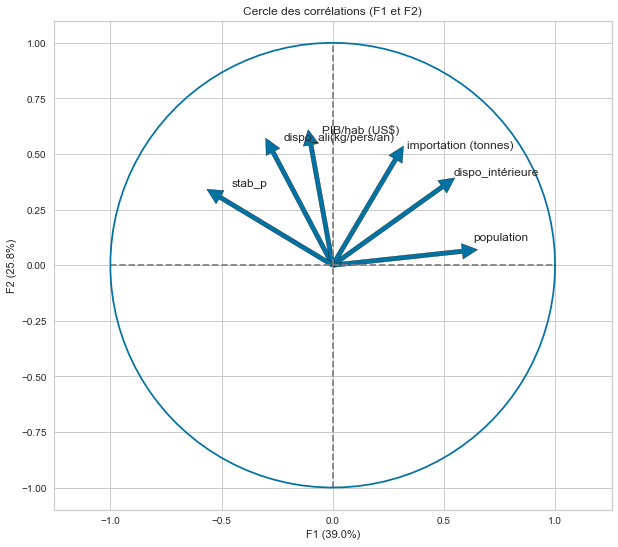

In [43]:
# F1 ET F2 CERCLE DES CORRELATIONS
ax1 = fig.add_subplot(131)
x, y = 0,1
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )
    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])  
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')
# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

## Projection des individus

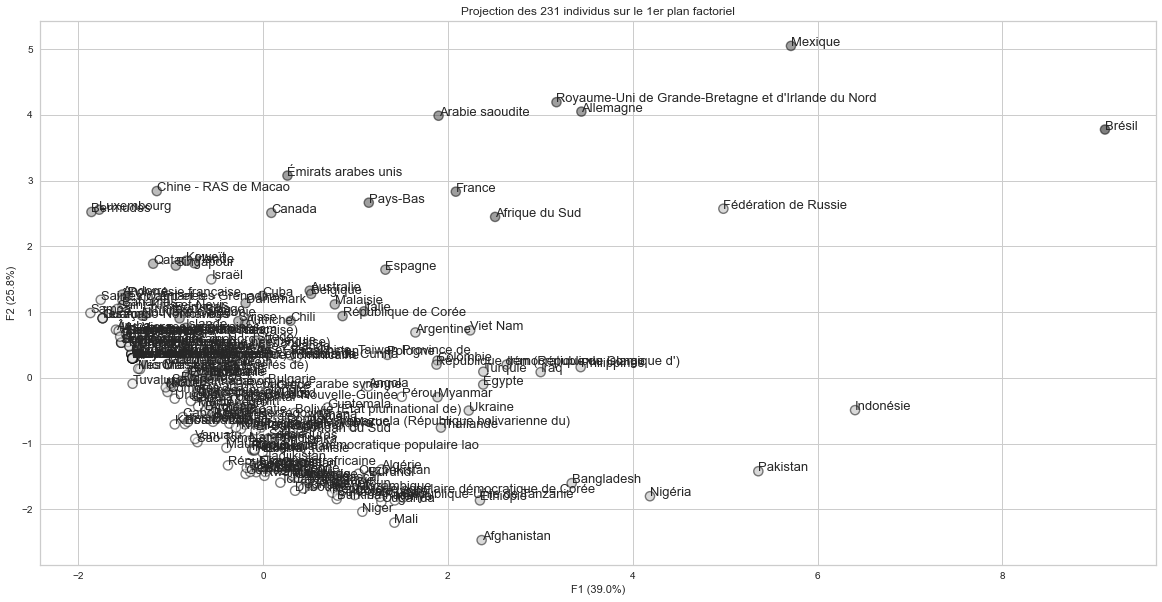

In [44]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)

# F1 ET F2
ax1 = fig.add_subplot(131) 
plt.figure(figsize=(20, 10))
plt.scatter(X_projected[:,0], X_projected[:, 1], c=model.labels_, 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)


for i,(x,y) in enumerate(X_projected[:,[0,1]]):
                    plt.text(x, y, df.index[i], fontsize='13') 
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.show()

## Analyse ACP

  
**Premier plan factoriel F1-F2** : représente 64.8% de la var expliquée (donc la meilleure puisque F1 et F2)
- On constate que toutes nos variables sont représentées de la même manière (longueur des flèches)
- Au niveau des angles, on voit que les variables dispo ali et PIB sont les plus correlées entres-elles

- F1 est fortement correlé positivement à population. Et toutes les autres variables sont faiblement correlés positivement.
- F2 est négativement correlé au PIB, dispo alimentaire et stabilité politique mais positivement correlée à importation, dispo intérieure et population. Le PIB étant le plus fortement correlé (négativement).

Donc

**F1 = Démographie d'un pays (quantitatif pop)**

**F2 =  Richesse d'un pays (santé économique PIB)**

(Le brésil pourrait être considéré comme un outlier) 

F1 abscisse - De gauche à droite

Sur la composante F1, plus un pays se trouve à droite (sur la projection des individus),plus sa population sera forte avec une stab politique faible et inversement vers la gauche. 

F2 Ordonnées - De bas en haut 

Sur la composante F2, plus un pays sera dans la partie inférieure, plus son PIB sera faible, s'il est dans la partie supérieure : plus son PIB sera haut.  

Ce que nous dit l'ACP sur les deux premières composantes c'est que les critères à retenir sont la richesse et la démographie d'un pays (on aimerait idéalement un pays avec un grand PIB et un nombre d'habitant optimal) 

Au vue de la projection des données, on pourrait se rapprocher des pays qui sont proches des caractéristiques de la France : Pays-bas, emirats arabes unis, Canada, arabie saoudite, allemagne, royaume-uni, afrique du sud, Espagne... 

On va affiner le résultat de nos clusters KMeans avec les 2 nouvelles composantes

In [45]:
#On obtient ici les coordonnées de nos pays sur les deux composantes principales 
Xs_projected = pca.transform(X_scaled)
df_acp = pd.DataFrame(Xs_projected, index=df.index,columns=["F" + str(i+1) for i in range(2)]).iloc[:, :2]
df_acp.head()

,F1,F2
zone,,
Afghanistan,2.37,-2.47
Afrique du Sud,2.51,2.45
Albanie,-0.43,-0.56
Algérie,1.28,-1.39
Allemagne,3.44,4.05


In [137]:
df_kmeans_acp = df_kmeans.set_index("zone")
df_kmeans_acp.head()

,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p,cluster_km
zone,,,,,,,
Afghanistan,0.48,-1.37,-0.32,-0.21,-0.87,-3.65,0
Afrique du Sud,1.04,0.63,2.01,3.33,-0.29,-0.24,1
Albanie,-0.43,-0.50,-0.33,-0.14,-0.34,0.29,0
Algérie,0.61,-1.09,-0.07,-0.40,-0.39,-1.47,0
Allemagne,1.73,-0.32,1.58,5.72,1.67,-0.24,1


In [138]:
#On va rajouter les cluster km sur ce nouveau df 
df_cls3 = pd.merge(df_acp, df_kmeans_acp['cluster_km'],how='inner', left_index=True, right_index=True)
df_cls3.head()

,F1,F2,cluster_km
zone,,,
Afghanistan,2.37,-2.47,0
Afrique du Sud,2.51,2.45,1
Albanie,-0.43,-0.56,0
Algérie,1.28,-1.39,0
Allemagne,3.44,4.05,1


In [139]:
#On regarde les centroides des clusters kmeans selon les composantes principales 
centroides_acp = df_cls3.groupby('cluster_km')['F1','F2'].mean()
centroides_acp

C:\Users\Camil\AppData\Local\Temp\ipykernel_5156\3122508308.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  centroides_acp = df_cls3.groupby('cluster_km')['F1','F2'].mean()


,F1,F2
cluster_km,,
0,0.38,-1.06
1,3.31,1.31
2,-0.95,0.57


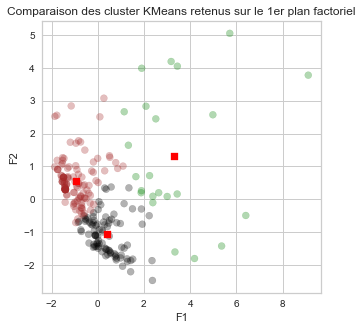

In [140]:
#Visualisation de nos 3 cluster km et leurs centroides via F1-F2
plt.figure(figsize=(5,5))
plt.title('Comparaison des cluster KMeans sur le 1er plan factoriel')
colormap=np.array(['black', 'green', 'brown'])
       
plt.scatter(df_cls3['F1'], df_cls3['F2'],c=colormap[df_cls3['cluster_km']], alpha=0.3)
plt.scatter(centroides_acp['F1'], centroides_acp['F2'], c='red', marker="s") #Centroïdes
plt.xlabel('F1')
plt.ylabel('F2')
plt.show()

Grâce a l'analyse de l'ACP et aux centroïdes, on sait que c'est le cluster 2 en vert qui correspondrait plus à nos critères + 2 points du cluster 3 (marron) comme on l'avait sélectionné dans la partie kmeans. On se basera donc plus sur la partie supérieure de F2 et milieu de F1 

On regardera les pays se rapprochant de la france : 

Pays-bas, emirats arabes unis, Canada, arabie saoudite, allemagne, royaume-uni, afrique du sud, Espagne...

In [123]:
#Les pays du cluster 2 kmeans : 
df_cls3[df_cls3['cluster_km']==1]

,F1,F2,cluster_km
zone,,,
Afrique du Sud,2.51,2.45,1
Allemagne,3.44,4.05,1
Arabie saoudite,1.90,3.99,1
Espagne,1.32,1.65,1
France,2.09,2.83,1
Mexique,5.71,5.05,1
Pays-Bas,1.14,2.67,1
République démocratique du Congo,1.88,0.20,1
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,3.18,4.19,1


## Comparaison résultats CAH et KMeans

In [141]:
compare = pays_KM[pays_KM['zone'].isin(pays_CAH['zone'])]
compare['zone'].unique()

array(['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'France',
       'Mexique', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
       'Andorre', 'Bahamas', 'Bermudes', 'Brunéi Darussalam', 'Canada',
       'Chypre', 'Cuba', 'Érythrée', 'Estonie', 'Finlande', 'Hongrie',
       'Îles Caïmanes', 'Îles Féroé', 'Irlande', 'Italie', 'Koweït',
       'Lettonie', 'Lituanie', 'Luxembourg', 'Malte', 'Norvège',
       'Nouvelle-Calédonie', 'Oman', 'Panama', 'Polynésie française',
       'Porto Rico', 'Portugal', 'Qatar', 'République de Corée',
       'Seychelles', 'Singapour', 'Slovaquie', 'Slovénie'], dtype=object)

In [142]:
# On a donc 39 pays similaires entre les deux méthodes kmeans et cah
len(compare['zone'])

39

In [134]:
# Sélection des 15 pays les plus avantageux avec sort_values 
pays_selectionnes = compare.sort_values(['population', 'dispo_intérieure',
       'importation (tonnes)', 'PIB/hab (US$)','stab_p']
        ,ascending=False).head(16) #+1 pour ne pas tenir compte de la france
pays_selectionnes['zone'].unique()

array(['Mexique', 'Allemagne',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'France',
       'Italie', 'Afrique du Sud', 'République de Corée', 'Canada',
       'Arabie saoudite', 'Cuba', 'Portugal', 'Hongrie', 'Singapour',
       'Finlande', 'Slovaquie', 'Norvège'], dtype=object)

Les critères de sélection étant : 

- La richesse du pays par son PIB
- Une stabilité politique convenable 
- La taille de sa population, plus il y en a mieux c'est
- Une bonne dispo intérieur : sélectionné pour la volaille donc = consommation de poulet, pareil plus il y en a, mieux c'est
- Un pays qui importe, car c'est le but d'importer le poulet depuis la France

La liste des 15 pays est plus optimisée et plus sélective pour le choix du pays afin d'entreprendre à l'international. 

In [135]:
#Liste des pays potentiels sur df normé 
pays_selectionnes.drop('cluster_km', axis=1, inplace=True)
pays_selectionnes

,zone,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p
134,Mexique,2.87,0.44,4.38,6.67,0.01,-0.24
4,Allemagne,1.73,-0.32,1.58,5.72,1.67,-0.24
180,Royaume-Uni de Grande-Bretagne et d'Irlande du...,1.30,0.41,2.14,5.26,1.33,-0.24
67,France,1.25,-0.12,1.39,3.27,1.24,0.32
106,Italie,1.14,-0.36,0.94,0.29,1.09,0.20
1,Afrique du Sud,1.04,0.63,2.01,3.33,-0.29,-0.24
171,République de Corée,0.88,-0.48,0.58,0.58,1.06,0.25
39,Canada,0.49,0.82,1.23,0.91,1.43,1.38
10,Arabie saoudite,0.39,1.08,1.24,4.84,1.38,-0.24
50,Cuba,-0.20,-0.07,0.00,1.86,0.31,0.80


In [144]:
#Résultat finaux:
df.reset_index()
result = df.loc[['Mexique', 'Allemagne',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
       'Italie', 'Afrique du Sud', 'République de Corée', 'Canada',
       'Arabie saoudite', 'Cuba', 'Portugal', 'Hongrie', 'Singapour',
       'Finlande', 'Slovaquie', 'Norvège']]
result.to_csv('results.csv')
result

,population,dispo_ali(kg/pers/an),dispo_intérieure,importation (tonnes),PIB/hab (US$),stab_p
zone,,,,,,
Mexique,"124,777,324.00",32.52,"4,219.00","972,000.00","19,721.30",-0.15
Allemagne,"82,658,409.00",19.47,"1,739.00","842,000.00","53,071.50",-0.15
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,"66,727,461.00",31.94,"2,234.00","779,000.00","46,372.40",-0.15
Italie,"60,673,701.00",18.88,"1,173.00","97,000.00","41,581.10",0.19
Afrique du Sud,"57,009,756.00",35.69,"2,118.00","514,000.00","13,860.30",-0.15
République de Corée,"51,096,415.00",16.70,854.00,"137,000.00","40,957.40",0.23
Canada,"36,732,095.00",39.02,"1,433.00","182,000.00","48,317.20",1.10
Arabie saoudite,"33,101,179.00",43.36,"1,435.00","722,000.00","47,306.20",-0.15
Cuba,"11,339,254.00",23.72,342.00,"312,000.00","25,855.90",0.65
